In [2]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# Read in data

In [ ]:
# Read in data 
root_dir = Path().resolve().parents[1]
data_dir = root_dir / "data" / "02-clean"

sauc_met_fpath = data_dir / "combined-sites.csv"
sauc_lcl_fpath = data_dir / "goes-extracted" / "sauc-lcl.csv"

sauc_met = pd.read_csv(sauc_met_fpath, index_col='time (PST)').drop('Unnamed: 0', axis=1)
sauc_lcl = pd.read_csv(sauc_lcl_fpath, index_col='time-PDT').drop('Unnamed: 0', axis=1)

# Preprocess
sauc_met.index = pd.to_datetime(sauc_met.index)
sauc_lcl.index = pd.to_datetime(sauc_lcl.index)
sauc_lcl.index = sauc_lcl.index - pd.Timedelta(hours=1) # Change PDT to PST
sauc_lcl.index.name = 'time (PST)'

# Join the dataframes
df = pd.concat([sauc_lcl, sauc_met], join='inner', axis=1)

# Create binary variables
df['fog-binary'] = df['fog'].apply(lambda x: 1 if x > 0 else 0)
df['cldalb-binary'] =df['cldalb'].apply(lambda x: 1 if x > 8.5 else 0)
df.head(2)

,cldalb,fog,air temperature (C),relative humidity (%),wind speed (m/s),wind gust (m/s),wind direction (deg),rain (mm),fog tips,fog-binary,cldalb-binary
time (PST),,,,,,,,,,,
2004-05-01 06:00:00,8.54,0.0,15.29,50.25,0.84,1.97,115.12,0.0,0.0,0,1
2004-05-01 06:30:00,6.34,0.0,17.19,46.23,0.56,1.38,147.98,0.0,0.0,0,0


In [4]:
df.isna().sum()
df.dropna(inplace=True)

In [5]:
print(df.index.min())
print(df.index.max())

2004-05-01 06:00:00
2009-09-30 17:30:00


In [6]:
# How many fog observations are there? 
df['fog-binary'].value_counts()

fog-binary
0    21613
1      623
Name: count, dtype: int64

In [7]:
df['cldalb-binary'].value_counts()

cldalb-binary
0    12772
1     9464
Name: count, dtype: int64

# EDA Plots

<Axes: xlabel='relative humidity (%)'>

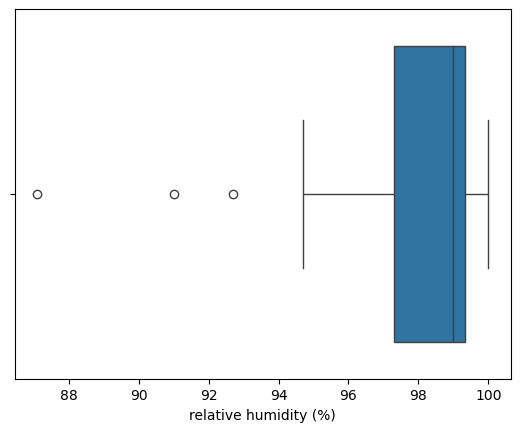

In [8]:
## What's the range of RH for fog drip? 
df_subset = df.loc[df['fog tips'] > 1]
sns.boxplot(data=df_subset,
            x='relative humidity (%)')

<Axes: xlabel='relative humidity (%)'>

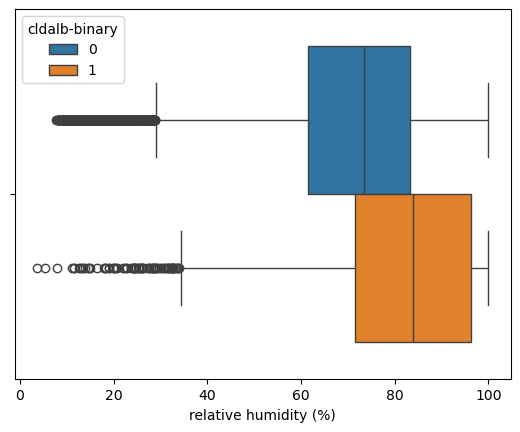

In [9]:
sns.boxplot(data=df,
            x='relative humidity (%)',
            hue='cldalb-binary')

In [10]:
# Create an RH fog variable
df['rh-fog'] = df['relative humidity (%)'].apply(lambda x: 1 if x > 97 else 0)
df['rh-fog'].value_counts()

rh-fog
0    19543
1     2693
Name: count, dtype: int64

## Box Plots

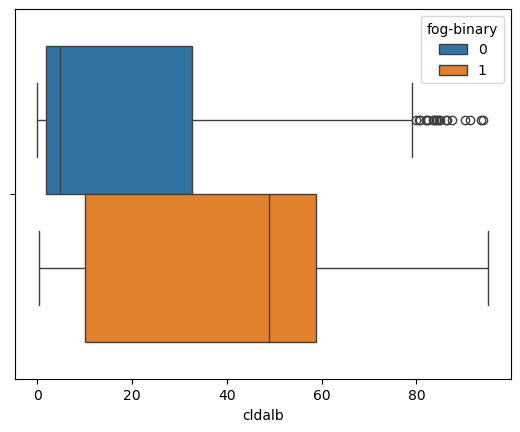

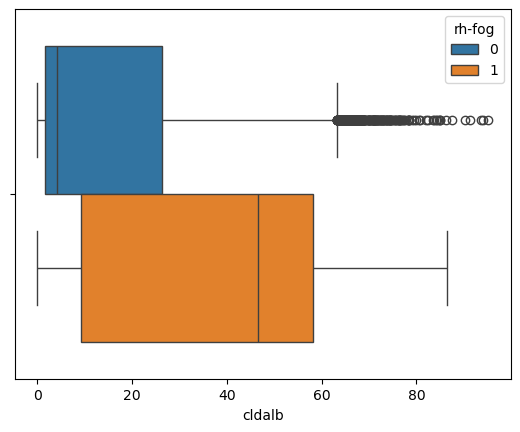

In [11]:
# Quick check 
sns.boxplot(data=df,
           x='cldalb',
           hue='fog-binary')
plt.show()

sns.boxplot(data=df,
           x='cldalb',
           hue='rh-fog')
plt.show()

## Histogram

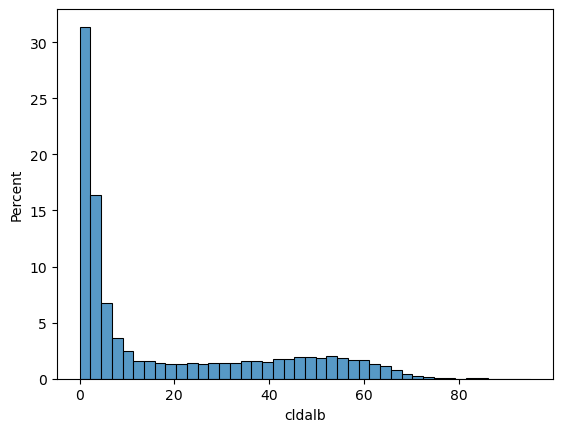

In [12]:
sns.histplot(data=df,
             x='cldalb',
             stat='percent')
plt.show()

## Correlation Matrix

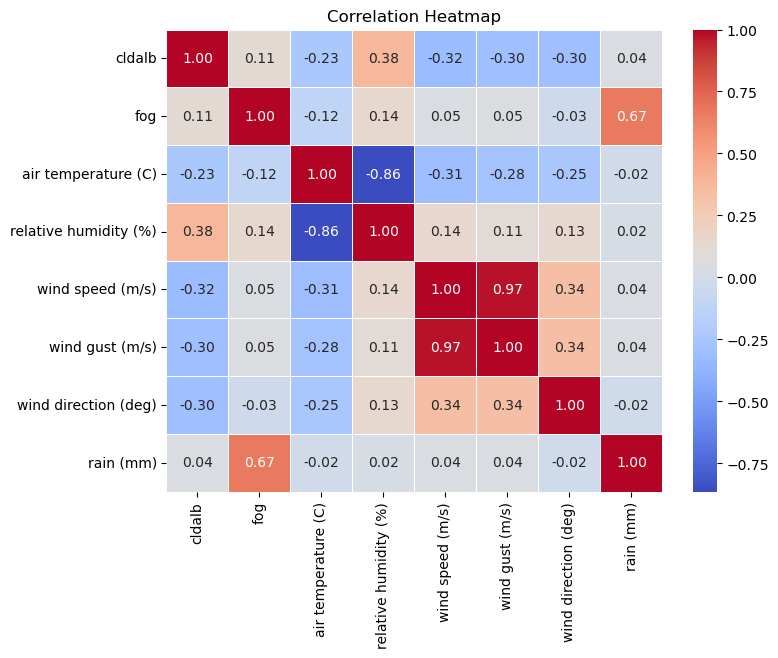

In [13]:
# Calculate the correlation matrix
corr_matrix = df[['cldalb', 'fog', 'air temperature (C)', 'relative humidity (%)',
       'wind speed (m/s)', 'wind gust (m/s)', 'wind direction (deg)',
       'rain (mm)']].corr()

# Create the heatmap
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

## Fog/LCL Agreeance

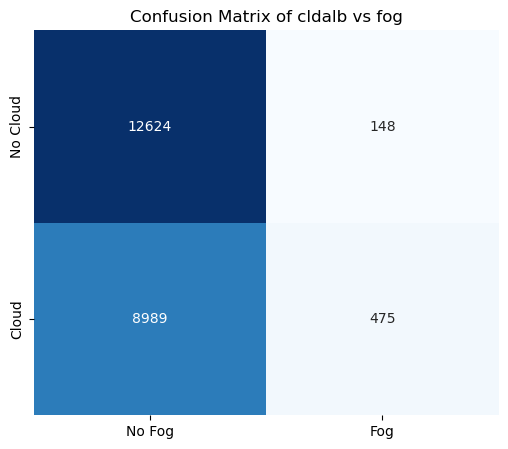

In [14]:
cm = confusion_matrix(df['cldalb-binary'], df['fog-binary'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No Fog', 'Fog'], yticklabels=['No Cloud', 'Cloud'])

# Add labels and title
plt.title('Confusion Matrix of cldalb vs fog')

# Show the plot
plt.show()

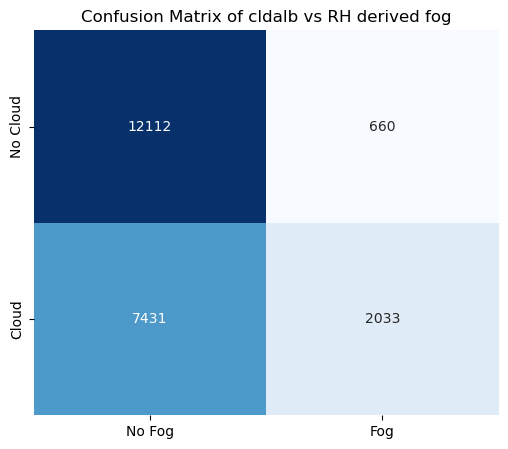

In [15]:
cm = confusion_matrix(df['cldalb-binary'], df['rh-fog'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No Fog', 'Fog'], yticklabels=['No Cloud', 'Cloud'])

# Add labels and title
plt.title('Confusion Matrix of cldalb vs RH derived fog')

# Show the plot
plt.show()

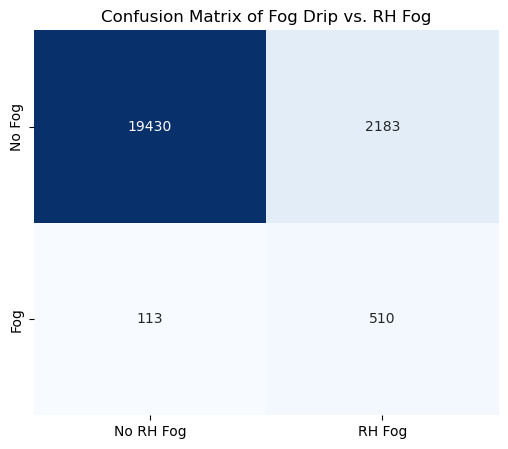

In [16]:
cm = confusion_matrix(df['fog-binary'], df['rh-fog'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No RH Fog', 'RH Fog'], yticklabels=['No Fog', 'Fog'])

# Add labels and title
plt.title('Confusion Matrix of Fog Drip vs. RH Fog')

# Show the plot
plt.show()

## Linear Regression

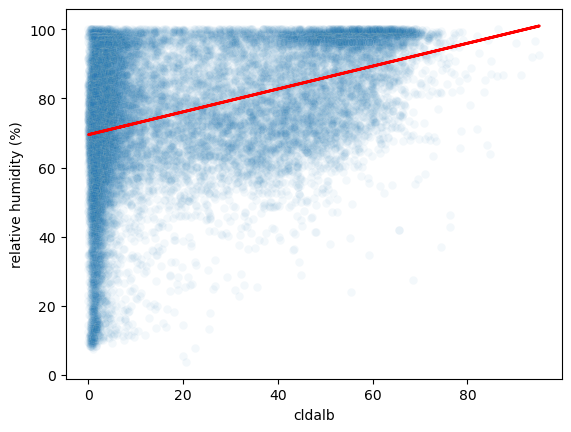

Intercept: [69.5285531]
Slope (Coefficient for cldalb): [0.3308775]
R-squared: 0.1453908484555949


In [17]:
model = LinearRegression()
model.fit(df[['cldalb']], df[['relative humidity (%)']])
y_pred = model.predict(df[['cldalb']])

# Create a seaborn scatterplot
sns.scatterplot(x='cldalb', y='relative humidity (%)', alpha=0.05, data=df)

# Plot the regression line
plt.plot(df['cldalb'], y_pred, color='red', linewidth=2)
plt.show()


# Get the regression results
intercept = model.intercept_
slope = model.coef_[0]  # Since we have only one feature, get the first coefficient
r_squared = model.score(df[['cldalb']], df[['relative humidity (%)']])  # R-squared value

# Print the results
print(f"Intercept: {intercept}")
print(f"Slope (Coefficient for cldalb): {slope}")
print(f"R-squared: {r_squared}")

# Funnel 